In [1]:
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.
# import time
import time
import numpy as np
import scipy.stats
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
mpl.rc('font', size=20)
mpl.rc('font', family='serif')
mpl.rc('figure', figsize=(16, 11))
mpl.rc('lines', linewidth=2)
mpl.rc('lines', markersize=12)
mpl.rc('figure.subplot', hspace=.3)
mpl.rc('figure.subplot', wspace=.1)
mpl.rc('animation', html='html5')
np.random.seed(0)

def Metropolis_Hastings(n, J, π, x0, q, q_sampler):
    # x0: Initial condition
    # n: Number of iterations
    # J: Number of particles

    # (Notice that, in fact, taking the minimum is not necessary)
    α = lambda x, y: np.minimum(1, π(y)*q(y, x) / (π(x)*q(x, y)))

    # Vector with trajectories
    x = np.zeros((n + 1, J), dtype=type(x0))

    # Initial condition
    x[0, :] = x[0, :] + x0

    for i in range(n):
        y = q_sampler(x[i])
        u = np.random.rand(J)

        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
        x[i + 1] = np.where(u < α(x[i], y), y, x[i])

    return x

# Discrete state space
We begin by illustrating the Metropolis-Hastings algorithm in the finite state space
$\{0, \dotsc, N-1\}$, for some natural number $N$.
Assume that we wish to sample from, or compute expectations with respect to, the following distribution:
$$
π(x) = \frac{1}{N}  \left(1 + .9 \, \sin \left( \frac{2 \pi x}{N} \right) \right).
$$

In [3]:
# Number of particles
J = 10000

# Number of steps
n = 100

# Size of discrete state space
N = 24

# Discrete state space
S = np.arange(N, dtype=int)

# Desired stationary distribution
π = lambda x: 1/N * (1 + .9 * np.sin(2*np.pi*(x/N)))

# Independence sampler with uniform proposal
q_indep = lambda x, y: 1/N
q_indep_sampler = lambda x: np.random.randint(0, N, size=len(x))

# Random walk Metropolis-Hastings
q_rwmh = lambda x, y: (1/2) * (y == (x + 1) % N) + (1/2) * (y == (x - 1) % N)
q_rwmh_sampler = lambda x: (x + (1 - 2*np.random.randint(0, 2, size=J))) % N

# Initial condition
x0 = 0

# Metropolis-Hastings
x_rwmh = Metropolis_Hastings(n, J, π, x0, q_rwmh, q_rwmh_sampler)
x_indep = Metropolis_Hastings(n, J, π, x0, q_indep, q_indep_sampler)

def anim_pmf(x, n_steps=n):
    def plot_pmf(i):
        ax.clear()
        ax.set_title("Probability mass function at iteration ${}$".format(i))
        ax.set_xlabel("$x$")
        x_plot, y_plot = np.unique(x[i], return_counts=True)
        ax.stem(x_plot - .05, y_plot/len(x[0]), use_line_collection=True,
                label="Metropolis-Hastings runs", linefmt='C0-', markerfmt='C0o')
        x_plot = np.arange(N)
        ax.stem(x_plot + .05, π(x_plot), use_line_collection=True,
                label="Target distribution", linefmt='C1-', markerfmt='C1o')
        ax.set_ylim(0, 0.2)
        ax.legend(loc="upper right")
        # time.sleep(1)

    mpl.rc('figure', figsize=(12, 8))
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.1, bottom=.1, right=.98, top=.95)
    iterate = lambda i: plot_pmf(i)
    anim = animation.FuncAnimation(fig, iterate, np.arange(n_steps), interval=600,
                                   init_func=lambda: None, repeat=True)

    # For Python
    # plt.show()

    # For notebook
    plt.close(fig)
    return anim

## Evolution of the PMF
### Independence sampler
In the animation, we plot the evolution of the pmf of the Markov chain.
We could have calculated the exact probability mass function (pmf) at each
iteration exactly by constructing the transition matrix and left-multiplying
by its transpose at each iteration, but here we opted for an estimation by
a usual Monte Carlo, based on the observation that the pmf at a point $x$ and
a time $n$ is simply $\mathbb E [\delta_{x}(X_n)]$, where $\{X_n\}$ is the
Markov chain generated by the Metropolis-Hastings algorithm.

In [4]:
anim_pmf(x_indep, n_steps=20)

### Random Walk Metropolis-Hastings
Here we use a proposal corresponding to a random walk on the finite domain,
with periodic boundary condition. More precisely, we use the proposal density (pmf)
$$
q(y \, | \, x) =
\begin{cases}
   1/2 \quad & \text{if $y = (x + 1) \% N$} \\
   1/2 \quad & \text{if $y = (x - 1) \% N$}
\end{cases}
$$

In [5]:
anim_pmf(x_rwmh)

## Calculating expectations
So far, we checked only that the Metropolis-Hastings algorithm produces a
Markov chain whose associated PMF converges to the target distribution as the discrete time tends to infinity,
indicating that the method is suitable for sampling: regardless of $X_0$,
for a sufficiently large time n the iterate $X_n$ is approximately distributed according to $\pi$.

Now we will examine whether the Markov chain can be used to estimate $I := \mathbb E_{X \sim \pi} [f(X)]$ based on one long trajectory.
Since $S := \{0, \dotsc, N-1\}$ is a finite state space,
any function on $S$ can be decomposed as $f(x) = \sum_{i=0}^{N-1} f(i) \, \delta_i(x)$,
i.e. as a linear combination of indicator functions.
This is why, in the Monte Carlo simulations below,
we estimate
$$
\mathbb E_{X \sim \pi} [\delta_i(X)] = \mathbb P_{X \sim \pi} [X = i] = \pi(i), \qquad i = 0, \dotsc, N-1.
$$

In [6]:
# Here we use only one trajectory, but a long one
J, n = 1, 2*10**4

# Metropolis-Hastings
x_rwmh = Metropolis_Hastings(n, J, π, x0, q_rwmh, q_rwmh_sampler)
x_indep = Metropolis_Hastings(n, J, π, x0, q_indep, q_indep_sampler)

def anim_averages(x, n_steps=100):
    def plot_averages(i):
        ax.clear()
        ax.set_title("Time averages of $\delta_i$ based on {} iterations".format(i))
        ax.set_xlabel("$i$")
        x_plot, y_plot = np.unique(x[:i, 0], return_counts=True)
        ax.stem(x_plot - .05, y_plot/i, use_line_collection=True,
                label="Time averages", linefmt='C0-', markerfmt='C0o')
        x_plot = np.arange(N)
        ax.stem(x_plot + .05, π(x_plot), use_line_collection=True,
                label="Target distribution", linefmt='C1-', markerfmt='C1o')
        ax.set_ylim(0, 0.2)
        ax.legend(loc="upper right")
        # time.sleep(1)

    mpl.rc('figure', figsize=(12, 8))
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.1, bottom=.1, right=.98, top=.95)
    iterate = lambda i: plot_averages(i)
    anim = animation.FuncAnimation(fig, iterate, np.arange(1, n, n // n_steps),
                                   interval=600, init_func=lambda: None, repeat=True)

    # For Python
    # plt.show()

    # For notebook
    plt.close(fig)
    return anim

### Independence sampler

In [7]:
anim_averages(x_indep, n_steps=20)

### Random Walk Metropolis-Hastings

In [8]:
anim_averages(x_rwmh, n_steps=20)

# Continuous state space
Let us now consider an example in continuous state-space.
Suppose that we wish to sample from the bimodal distribution,
given by the following expression up to the normalization constant:
$$
\newcommand{\e}{\mathrm{e}}
\pi(x) = \e^{-(x^2 - 1)^2}.
$$

In [9]:
# Number of particles
J = 10000

# Number of steps
n = 1000

# Desired stationary distribution
π = lambda x: np.exp(- (x**2 - 1)**2)

# Calculate the normalization constant (this is not necessary for MH, but will
# be useful for the plots)
Z = scipy.integrate.quad(π, -np.inf, np.inf)[0]

# Independence sampler with uniform proposal
# Normalization not necessary (do you understand why?)
q_indep = lambda x, y: np.exp(-y**2/2)
q_indep_sampler = lambda x: np.random.randn(len(x))

# Family of proposals for random walk Metropolis-Hastings
q_rwmh = lambda δ: (lambda x, y: np.abs(y - x) < δ)
q_rwmh_sampler = lambda δ: (lambda x: x + δ*(.5 - np.random.rand(len(x))))

# Initial condition
x0 = -1.

# Independence sampler
x_indep = Metropolis_Hastings(n, J, π, x0, q_indep, q_indep_sampler)

# Three values of δ
δ1, δ2, δ3 = .01, .1, 1
x_rwmh_2 = Metropolis_Hastings(n, J, π, x0, q_rwmh(δ2), q_rwmh_sampler(δ2))
x_rwmh_3 = Metropolis_Hastings(n, J, π, x0, q_rwmh(δ3), q_rwmh_sampler(δ3))

def anim_pdf(x, n_steps, step):

    def plot_pdf(i):
        ax.clear()
        ax.set_title("Probability density function at iteration ${}$".format(i))
        ax.set_xlabel("$x$")
        L, N = 4, 200
        x_plot = np.linspace(-L, L, N)
        ax.plot(x_plot, π(x_plot) / Z, label="Target distribution")
        ax.hist(x[i], bins=20, density=True, label="Metropolis-Hastings runs")
        ax.set_ylim(0, 0.7)
        ax.set_xlim(-4, 4)
        ax.legend(loc="upper right")
        # time.sleep(1)

    mpl.rc('figure', figsize=(12, 8))
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.1, bottom=.1, right=.98, top=.95)
    iterate = lambda i: plot_pdf(i)
    anim = animation.FuncAnimation(fig, iterate, np.arange(0, n_steps, step),
                                   interval=600, init_func=lambda: None, repeat=True)
    plt.close(fig)
    return anim

## Independence sampler

In [10]:
anim_pdf(x_indep, 20, 1)

## RWMH with $\delta = 1$

In [11]:
anim_pdf(x_rwmh_3, 40, 1)

## RWMH with $\delta = .1$

In [12]:
anim_pdf(x_rwmh_2, n, 20)

## Long trajectories

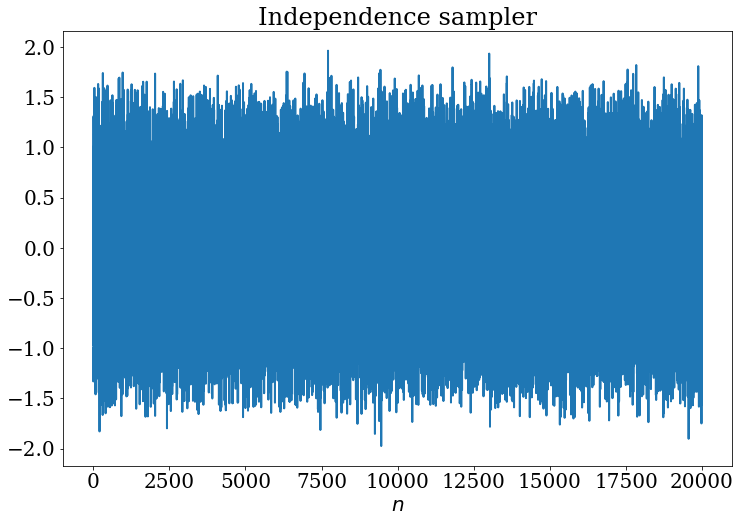

In [13]:
# Number of particles
J = 1

# Number of steps
n = 2 * 10**4

# Independence sampler
x_indep = Metropolis_Hastings(n, J, π, x0, q_indep, q_indep_sampler)

# Three values of δ
x_rwmh_1 = Metropolis_Hastings(n, J, π, x0, q_rwmh(δ1), q_rwmh_sampler(δ1))[:, 0]
x_rwmh_2 = Metropolis_Hastings(n, J, π, x0, q_rwmh(δ2), q_rwmh_sampler(δ2))[:, 0]
x_rwmh_3 = Metropolis_Hastings(n, J, π, x0, q_rwmh(δ3), q_rwmh_sampler(δ3))[:, 0]

fig, ax = plt.subplots()
t = np.arange(n + 1)
ax.plot(t, x_indep[:, 0])
ax.set_title("Independence sampler")
ax.set_xlabel("$n$")
plt.show()

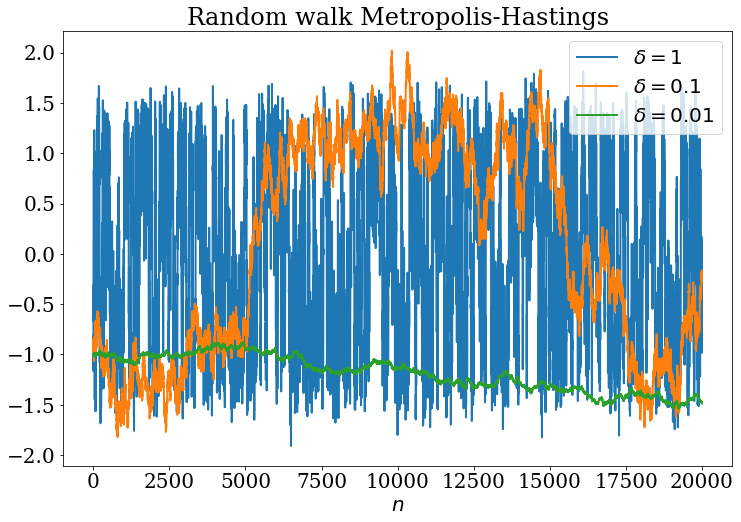

In [14]:
fig, ax = plt.subplots()
t = np.arange(n + 1)
ax.plot(t, x_rwmh_3, label=r"$\delta = {}$".format(δ3))
ax.plot(t, x_rwmh_2, label=r"$\delta = {}$".format(δ2))
ax.plot(t, x_rwmh_1, label=r"$\delta = {}$".format(δ1))
ax.set_title("Random walk Metropolis-Hastings")
ax.set_xlabel("$n$")
ax.legend()
plt.show()